# DCGAN on Bricks Dataset

In [1]:
import os
from PIL import Image
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary
from torcheval import metrics as Metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 300
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1)])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    print('Train data size: ', len(lego_dataset))
    print('Num. train batchs: ', len(train_loader))
    return train_loader

In [5]:
def display_imgs(imgs):
    plt.figure(figsize=(14, 3))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        ax.imshow(imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

Train data size:  40000
Num. train batchs:  313
torch.Size([128, 1, 64, 64])


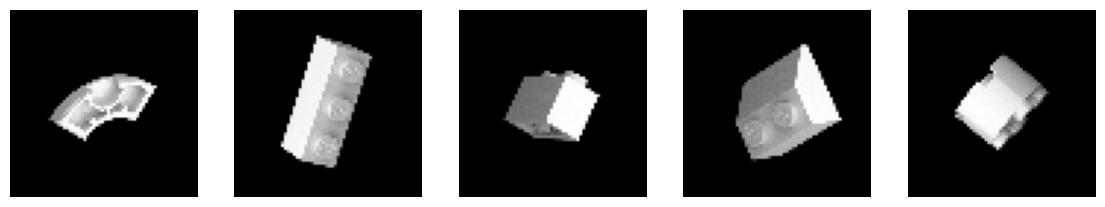

In [6]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)

# test = Discriminator().to(DEVICE)
# summary(test, (1, 64, 64))

In [8]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x

    
    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

# generator = Generator(Z_DIM).to(DEVICE)
# summary(generator, (100,))

In [9]:
class DCGAN(nn.Module):
    
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()


    def forward(self, real_imgs):
        latents = torch.randn(size=(len(real_imgs), self.z_dim)).to(DEVICE)
        generated_imgs = self.generator(latents)

        real_preds = self.discriminator(real_imgs)
        fake_preds = self.discriminator(generated_imgs)
        
        return real_preds, fake_preds, generated_imgs

dcgan = DCGAN(Z_DIM).to(DEVICE)
summary(dcgan, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

## 3. Define the model, objective, and optimizer

In [10]:
dcgan = DCGAN(Z_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    dcgan = torch.compile(dcgan, backend='eager')
    print('model compiled')

loss_fn = nn.BCELoss()
d_optim = torch.optim.Adam(params=dcgan.discriminator.parameters(), lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=dcgan.generator.parameters() ,lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))

train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
    'd_real_acc': Metrics.BinaryAccuracy(),
    'd_fake_acc': Metrics.BinaryAccuracy(),
    'g_acc': Metrics.BinaryAccuracy(),
}

model compiled


## 4. Get dataloader

In [11]:
lego_dataloader = get_dataloader()

Train data size:  40000
Num. train batchs:  313


## 5. Train step function

In [12]:
def train(model, dataloader, d_optim, g_optim, loss_fn, train_metrics):
    
    model.train() # Set model to train mode
    for metric in train_metrics.values():
        metric.reset() # clear metrics data

    for i, train_imgs in enumerate(dataloader):
        d_optim.zero_grad()
        g_optim.zero_grad()

        train_imgs = train_imgs.to(DEVICE)
        real_preds, fake_preds, generated_imgs = model(train_imgs)
        real_label = torch.ones_like(real_preds)
        real_noisy_label = real_label + NOISE_PARAM * torch.randn(size=real_label.shape, device=DEVICE)
        
        fake_label = torch.zeros_like(fake_preds)
        fake_noisy_label = fake_label - NOISE_PARAM * torch.randn(size=fake_label.shape, device=DEVICE)

        d_real_loss = loss_fn(real_preds, real_noisy_label)
        d_fake_loss = loss_fn(fake_preds, fake_noisy_label)

        # Update discriminator
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward(retain_graph=True)
        d_optim.step()

        # update generator
        g_loss = loss_fn(fake_preds, real_label)
        g_loss.backward()
        g_optim.step()

        # Update metrics
        train_metrics['d_loss'].update(d_loss.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['d_fake_acc'].update(fake_preds.reshape(-1).detach().cpu(), fake_label.reshape(-1).detach().cpu())
        train_metrics['d_real_acc'].update(real_preds.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())
        train_metrics['g_acc'].update(fake_preds.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())

        del d_loss, g_loss, fake_preds, real_preds, real_label, real_noisy_label, fake_label, fake_noisy_label 

    return generated_imgs

## 6. Train DCGAN

In [13]:
for i in range(EPOCHS):
    prev_time = time.time()
    generated_imgs = train(dcgan, lego_dataloader, d_optim, g_optim, loss_fn, train_metrics)
    curr_time = time.time()
    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    for key, value in train_metrics.items():
        print(f'\t{key}, {value.compute().item():.4f}')
    

Epoch: 1	epoch time 0.37 min
	d_loss, 0.1624
	g_loss, 5.3271
	d_real_acc, 0.9388
	d_fake_acc, 0.9383
	g_acc, 0.0617
Epoch: 2	epoch time 0.36 min
	d_loss, 0.0829
	g_loss, 5.0536
	d_real_acc, 0.9759
	d_fake_acc, 0.9719
	g_acc, 0.0281
Epoch: 3	epoch time 0.36 min
	d_loss, 0.0595
	g_loss, 6.1409
	d_real_acc, 0.9822
	d_fake_acc, 0.9817
	g_acc, 0.0183


KeyboardInterrupt: 